In [ ]:
#### 다음 실습 코드는 학습 목적으로만 사용 바랍니다. 문의 : audit@korea.ac.kr 임성열 Ph.D.

'''Python 3.13에서는 아직 TensorFlow가 공식 지원 안됨. Python 3.11 이하 (특히 3.9, 3.10, 3.11) 사용 권고

# 여러 버전의 Python을 설치하고 관리해야 한다면, pyenv 또는 anaconda 등으로 여러 버전의 Python 설치 후 프로젝트별 버전 전환 관리할 수 있음
# 또는 직접 수동으로 각각 Python 버전 설치도 가능하나 각 실행 파일 디렉토리 위치 경로를 수작업으로 관리 필요

# 파이썬 버전 제어 및 범용 개발이 중심이라면 → 🧑‍💻 pyenv + venv/poetry 조합 추천
# 데이터 과학/머신러닝 중심이라면 → 🎯 Anaconda (또는 Miniconda) 권장
# 빠른 개발 및 배포 → 📦 forge는 최근 등장한 관리 도구로 Jupyter 환경 설정 별도 필요, 아직 패키지 배포 자동화 및 GPU 지원 미비

# Python 버전 낮추기 또는 여러 버전 이용 (예시) : 

# 🧑‍💻 pyenv 설치 후, pyenv install 3.10.13
# pyenv global 3.10.13   # 또는 pyenv local 3.10.13 (현재 폴더만)
# pip install numpy matplotlib pandas scikit-learn tensorflow

# 🎯 anaconda (https://www.anaconda.com/products/distribution) 설치 후 
# conda create -n tf python=3.10.13
# conda activate tf
# pip install numpy matplotlib pandas scikit-learn tensorflow

# 🧪 모두 다 설치했다면 → 하나의 목적에만 집중해 사용하는 것이 충돌 방지에 좋음'''

# Installing the packeges
# graphviz는 먼저 OS 패키지 설치 필요 (apt-get install graphviz 또는 brew install graphviz)
!pip install numpy matplotlib pandas scikit-learn tensorflow pydot graphviz
!python3 -m pip install ipykernel -U --force-reinstall # ipykernel 패키지를 설치 (Jupyter 커널용)

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

import math
from sklearn.metrics import mean_squared_error

In [8]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# Connectiing Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Loading the data
dataset = pd.read_csv('/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/uploaded_files/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


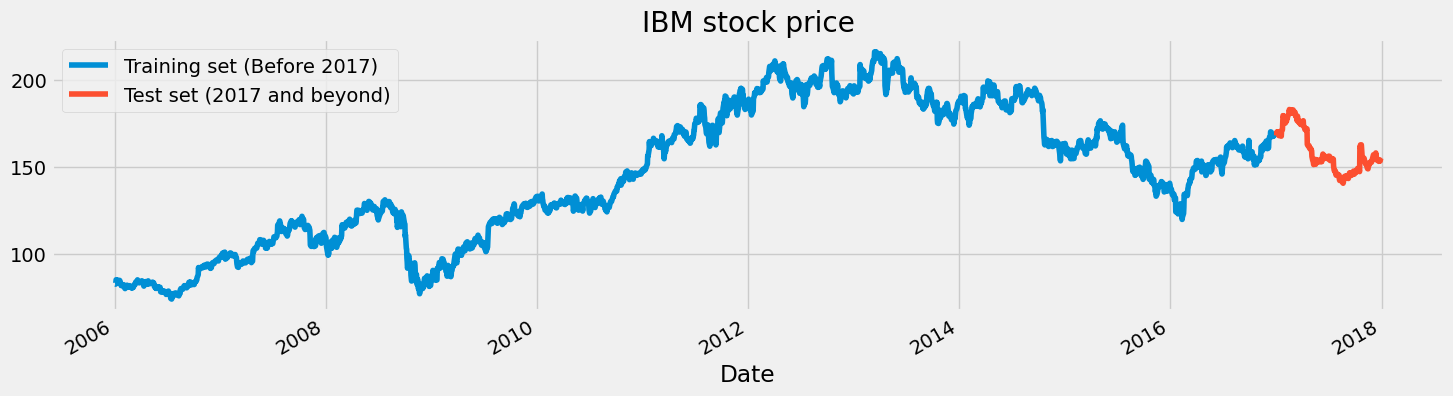

In [4]:
# Checking for missing values
# 2016년도이전 데이터에서 2번째 컬럼 값을 가져와서 저장합니다.
training_set = dataset[:'2016'].iloc[:,1:2].values
# 2017년도이후 데이터에서 2번째 컬럼 값을 가져와서 저장합니다.
test_set = dataset['2017':].iloc[:,1:2].values

# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [5]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
# LSTM 시계열 분석을 위해, Timesteps를 60으로 할 것이므로 60행 이후 데이터부터 사용 가능
# 데이터 셋을 보면, 2016년 데이터가 전체 2769개 존재함
for i in range(60,2769): 
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
# Timesteps와 MinMaxScaler 등을 적용한 대상 데이터를, LTSM Layer 입력에 용이하게 재배치
# shape[0]는 전체 행의 갯수, shape[1]은 전체 열의 갯수인데.. 상기 np 배열에 넣은 형태로 여기서는 잘라낸 Timesteps 갯수
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
# X_train = np.reshape(X_train, (2709,60,1))을 뜻하며, 2016년이전 2709개의 행을 60개씩 끊어낸 값 1행으로 
# LSTM (시계열성 데이터 변경 이력 예측에 특화된 RNN모델) input_shape에 맞게 3차원 배열로 재구성

# The LSTM architecture
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense

regressor = Sequential()

# 입력 정의 (X_train: (samples, timesteps, features) 가정)
regressor.add(Input(shape=(X_train.shape[1], 1)))

# First LSTM layer with Dropout regularisation
# 50개의 노드를 사용하여 RNN, LSTM 방식으로 입력층, 은닉층 생성
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# 전체 가능한 데이터 범위는 2709행에 대해서 60개 단위로 자동 계산되므로 생략
# 60개씩 끊어내서, 1개의 Feature에 대해서 예측

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))
# 최종 결과가 60개씩 시계열 이력 데이터를 끊어낸 단위에 대해 학습한 결과, 값 예측이므로 마지막 노드는 1개로 처리
# 단, MNIST 이미지 데이터와 같이, 0~9까지 표현을 위해 최종 노드를 사용하는 경우 10개 노드 필요

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0204
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0104
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0086
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0067
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0062
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0058
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0049
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0049
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0045
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0042
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0041
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0037
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0035
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0035
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0033
Epoc

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


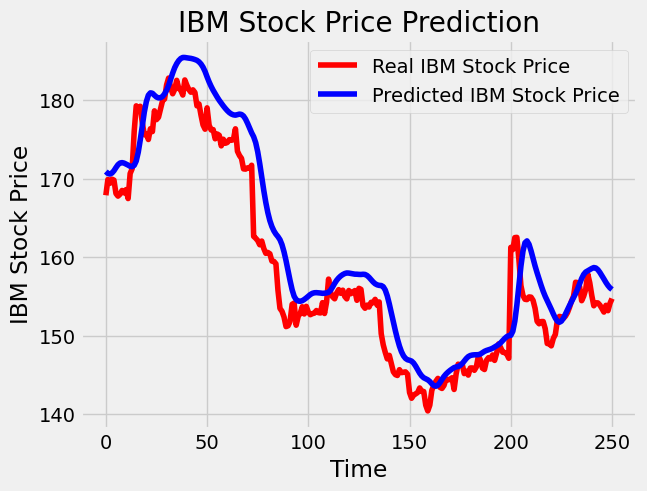

In [9]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [10]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.2106883089880895.


In [11]:
# 1. 모델 저장하기
from keras.models import load_model

# regressor.save('/content/drive/MyDrive/data/stock_lstm_model_nogpu.h5')
regressor.save('/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/model/stock_lstm_model_nogpu.keras')

In [12]:
# 2. 모델 불러오기
import pandas as pd
from keras.models import load_model

# Connectiing Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Loading the model
model = load_model('/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/model/stock_lstm_model_nogpu.keras')

# Loading the data
dataset = pd.read_csv('/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/uploaded_files/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

# We have chosen 'High' attribute for prices.
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


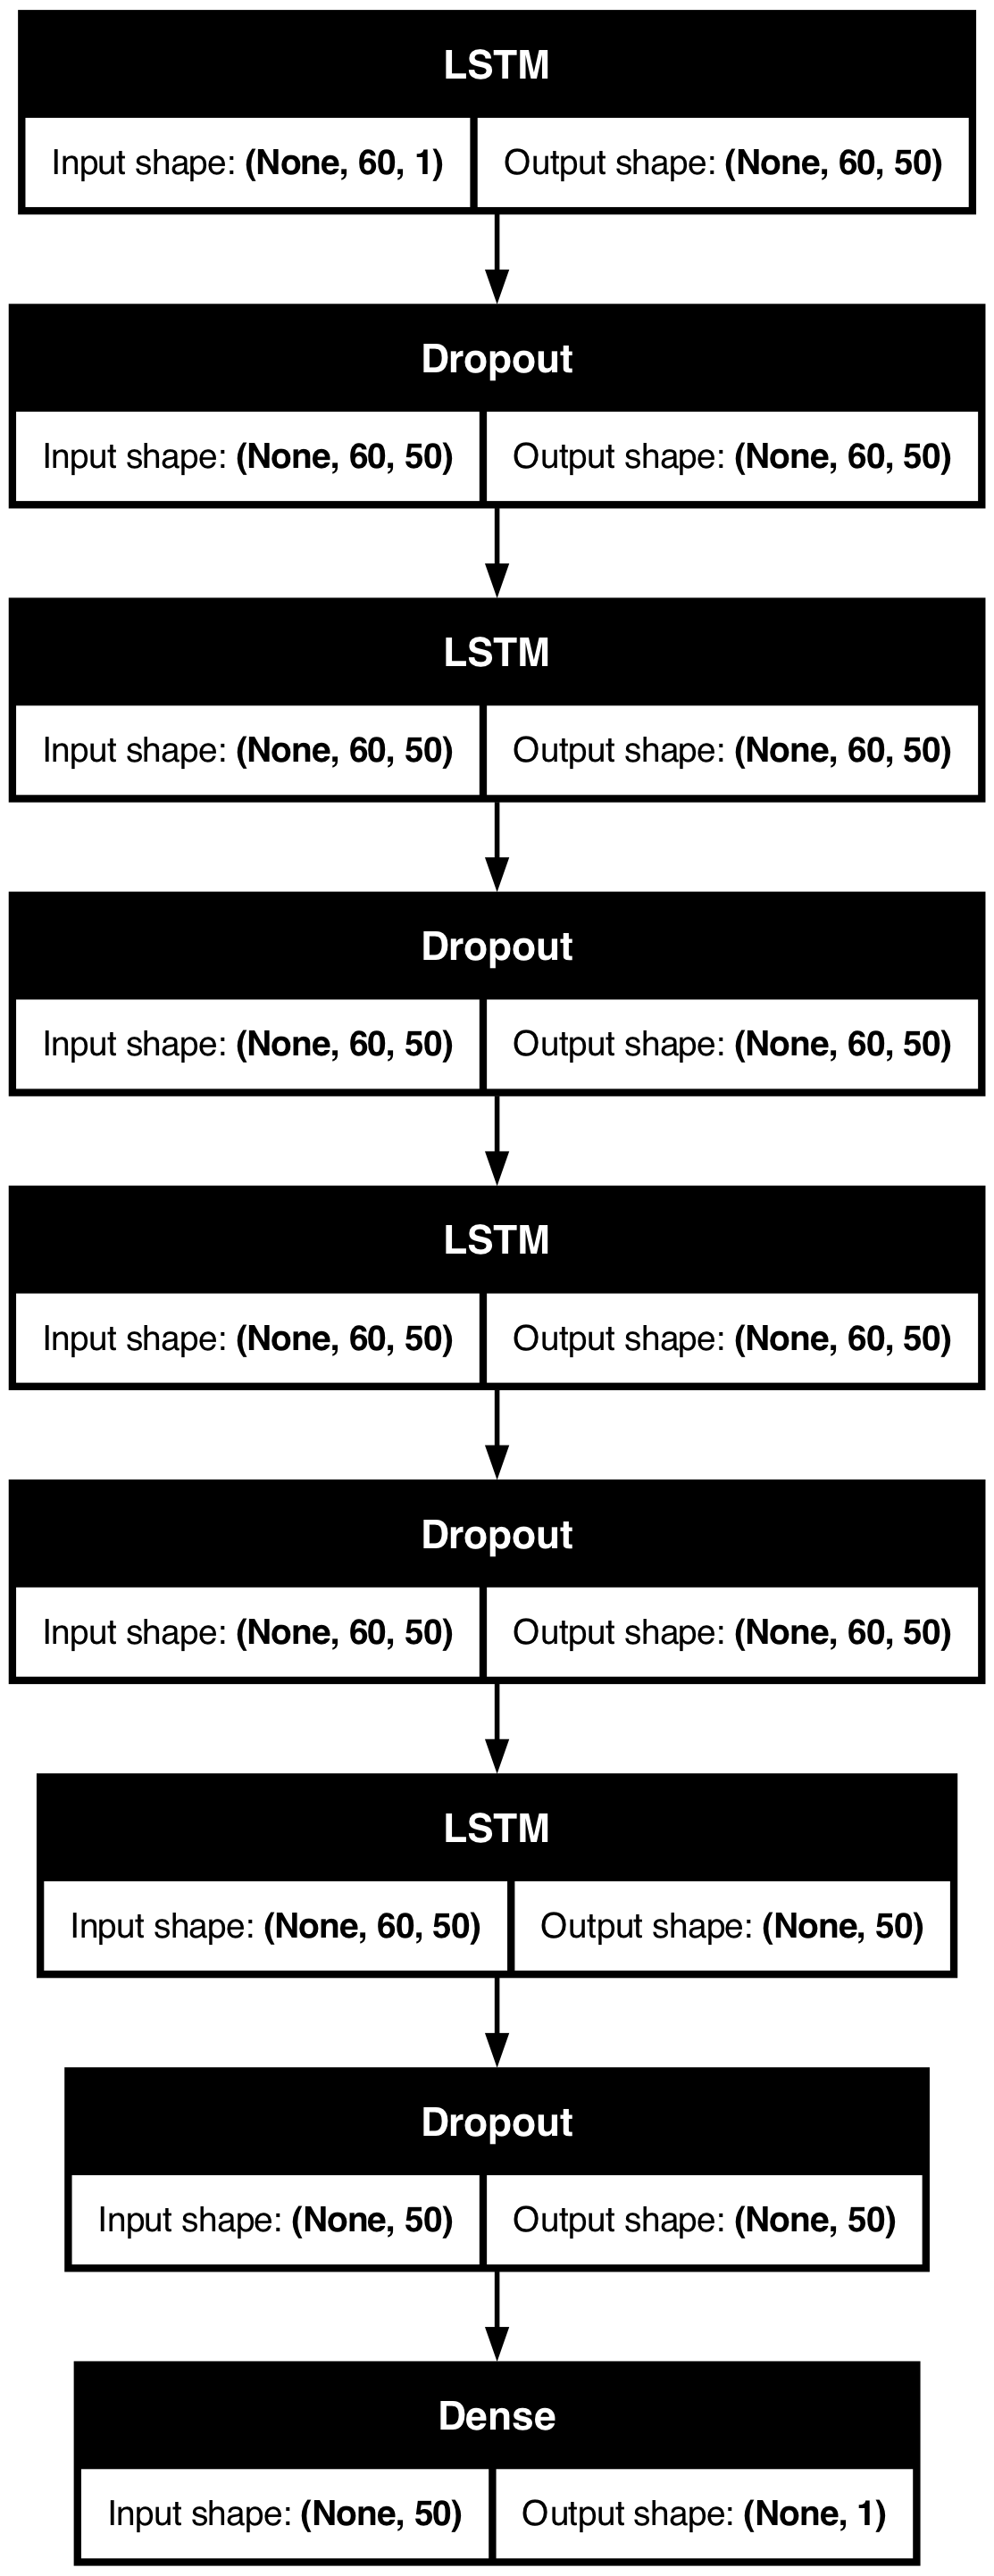

In [13]:
# 3. 모델 아키텍처 보기
from keras.utils import plot_model
import pydot
import graphviz

# plot_model(model, to_file='/content/drive/MyDrive/data/model.png')
# plot_model(model, to_file='/content/drive/MyDrive/data/model_shapes.png', show_shapes=True)

plot_model(model, to_file='/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/model-images/model_service.png')
plot_model(model, to_file='/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/model-images/model_shapes.png', show_shapes=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


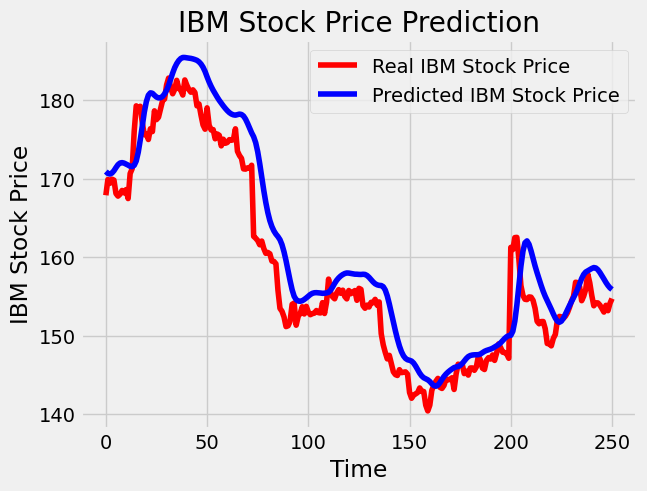

In [15]:
# 4. 모델 사용하기
'''사용 순서
1. 데이터 파일을 입력 받아서 IBM_2006-01-01_to_2018-01-01.csv
2. 로딩한 모델로 예측한 후에 stock_lstm_model.keras
3. 결과를 stock.png 파일로 생성하여 내보내는 순서'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential # 모델 학습 시에 사용하였으나, 모델을 재사용하는 것이므로 불필요
# from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional # 모델 학습 시에 사용하였으나, 모델을 재사용하는 것이므로 불필요
import math
from sklearn.metrics import mean_squared_error

# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
  # plt.show()
  # plt.savefig('/content/drive/MyDrive/data/stock.png')
    plt.savefig('/Users/phoenix/Eagle/2025_MLOps/service_model/model_serving/server/model-images/stock.png')  

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [16]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.2106883089880895.


In [17]:
import sys
print(sys.version)

3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 16.0.0 (clang-1600.0.26.6)]
